In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2
import math

Ejercicio 1: Filtros espectrales

Los filtros espectrales gaussianos son de tipo suavizado o pasa bajos, estos permiten difuminar las imagenes. Para este ejercicio se crea una funcion ("create_gauss_filter") que retorna el kernel y su tranformada. El proceso de funcion es el siguiente:

1. Se crea un contenedor con zeros del tamaño de la imagen
2. Se crea 2 matrices con ceros de tamaño k x k
3. Se reemplaza con valores de crecientes las 2 matrices para formar los kernels x e y
4. Se aplica la formula gaussiana con entradas: kernels y sigma
5. Se centra el resultado de las matrices en el contenedor de zeros
6. Se aplica fft al contenedor para obtner el kernel transformado

Nota: Se agregó el parametro "metodo" que cambia la forma de realizar el kernel gaussiano, 'function' crea el kernel desde la funcion de opencv y 'equation' lo hace desde cero.

In [2]:
def create_gauss_filter(h,w,ksize,sigma,metodo):

    # Filtro espacial
    container = np.zeros((h,w))
    if metodo == 'function':
        # entrega un vector de ksizex1 que separa el filtro
        g = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
    elif metodo == 'equation':
        mat_x = np.zeros((ksize,ksize))
        mat_y = np.zeros((ksize,ksize))

        if ksize%2==1:
            beta = math.floor(ksize/2)
        else:
            beta = int(ksize/2 -1)

        for i in range(beta):
            mat_x[:,i] = -(beta-i)
            mat_x[:,ksize-i-1] = (beta-i)

            mat_y[i,:] = -(beta-i)
            mat_y[ksize-i-1,:] = (beta-i)

        g = (1/((2*np.pi)*sigma**2)) * np.exp(-(mat_x**2 + mat_y**2)/(2*sigma**2))
        g = g/np.sum(g)
    
    container[round((h-ksize)/2):ksize+round((h-ksize)/2),
              round((w-ksize)/2):ksize+round((w-ksize)/2)] = g
    
    # Filtro en transformada
    kernel_fft = np.fft.fft2(container)
    


    return container,kernel_fft

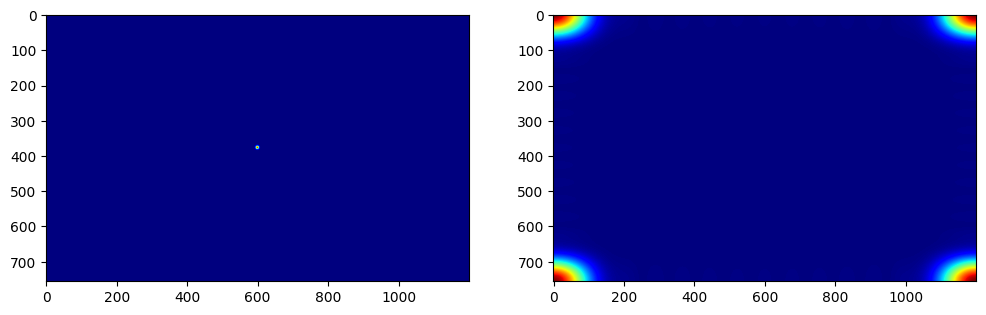

In [4]:
# se lee la imagen en escala de grises
img = cv2.imread("materiales/chewbacca.jpg",cv2.IMREAD_GRAYSCALE)

# se aplica la funcion creada
kernel_esp,kernel_fft = create_gauss_filter(img.shape[0],img.shape[1],15,3,'equation')


plt.figure(figsize=(12,10))
plt.subplot(1,2,1),plt.imshow(kernel_esp, cmap='jet')
plt.subplot(1,2,2),plt.imshow(np.abs(kernel_fft), cmap='jet')
plt.show()

Se aplica la transformada mediante la multiplicacion en el dominio de fourier, luego se aplica el acondicionamiento de inversa y central el resultado para observarlo en el dominio espacial.

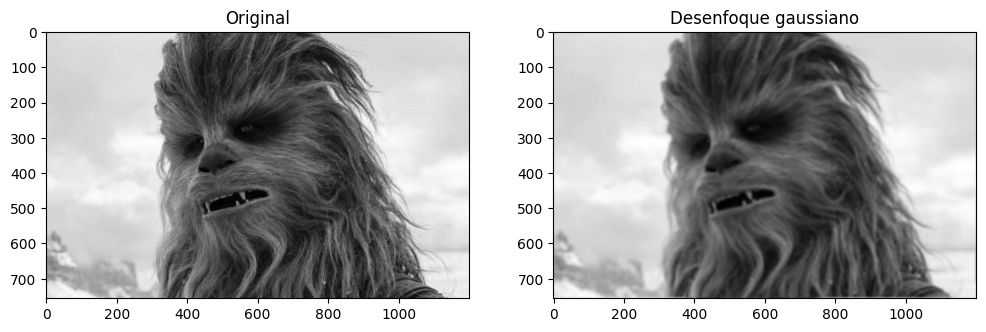

In [5]:
kernel_fft = np.fft.fft2(kernel_esp)
img_fft = np.fft.fft2(img)

filtered = img_fft * kernel_fft

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(12,10))
plt.subplot(1,2,1),plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1,2,2),plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gaussiano')
plt.show()

Ejercicio 2 : Paper 1

En el paper se describe un agoritmo para calcular una metrica de calidad de imagen. El algoritmo se define en la funcion "MetricQuality", a continuacion se describe el proceso:

1. Se obtiene la transformada de fourier de la imagen
2. Se calcula el valor absoluto de la transformada
3. Se obtiene el maximo valor de la matriz de valores absolutos
4. Se obtiene la cantidad de valores mayores al umbral de M/1000
5. Se calcula la metrica o medida dividiendolo entre el tamaño total de la matriz de la imagen original


In [6]:
def MetricQuality(image):
    F = np.fft.fft2(image)
    AF = np.abs(np.fft.fftshift(F))
    M = np.max(AF)
    Th = np.sum(F>(M/1000))
    FM = Th/(image.shape[0]*image.shape[1])

    return FM

In [7]:
print('Metrica con el filtro espectral:    ',MetricQuality(img_gauss))

gauss = cv2.GaussianBlur(img, (15,15), 3).astype('float64')
print('Metrica con filtro por convolucion: ',MetricQuality(gauss))

Metrica con el filtro espectral:     0.0007043650793650794
Metrica con filtro por convolucion:  0.0007330246913580247


Ejercicio 3:  Paper 2

La metrica elegida del paper 2 es la medida de enfoque Brenner's, esto se calcula mediante el siguiente proceso:

1. Se crean matriz de zeros con el mismo tamaño de la imagen de entrada
2. Se realiza la diferencia entra la misma imagen desplazada en 2 posiciones, este paso se realiza en horizontal y vertical.
3. Se almacena el resultado en las matrices creadas con zeros.
4. Se elige el maximo valor entre cada valor de las matrices resultantes horizontal y vertical.
5. Se calcula la potencia de 2 de la matriz resultante de 4
6. Se calcula el promedio (este paso puede ser cambiado por la suma total)

In [8]:
def MetricBenner(image):
    v = np.zeros((image.shape[0],image.shape[1]))
    h = np.zeros((image.shape[0],image.shape[1]))

    v[0:image.shape[0]-2,:] = image[0:-2,:] - image[2::,:]
    h[:,0:image.shape[1]-2] = image[:,0:-2] - image[:,2::]

    mayor = np.maximum(v,h)
    fm = np.power(mayor,2)

    #resul1 = np.sum(fm)
    resul = np.mean(fm)
    return resul

In [9]:
print('Metrica con el filtro espectral:    ',MetricBenner(img_gauss))

print('Metrica con filtro por convolucion: ',MetricBenner(gauss))

Metrica con el filtro espectral:     12.971011702568742
Metrica con filtro por convolucion:  12.839260361552029


Conclusiones:

- Se logra implementar un filtro gaussiano general con parametros de entrada el tamaño y sigma.
- El filtro gaussiano a mayor tamaño o mayor sigma se obtiene un mayor nivel de suavizado.
- En las dos metricas de calidad de imagen implementadas se obtiene valores similares.
- En el paper 2 se elige la medida de Brener´s, esta ecuacion se describe mejor en el paper de Santos de 1997.